# **Install and Load Packages**

In [ ]:
# Install tensorflow-addons for optimizer
! pip install tensorflow-addons

In [ ]:
import os
import glob
import datetime
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.utils import plot_model
from tensorflow.keras.regularizers import L2
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense, LeakyReLU, BatchNormalization
from tensorflow.keras import layers
from tensorflow import keras
import tensorflow_addons as tfa
import pickle
from sklearn.metrics import precision_recall_fscore_support
# Import the context normalization layer
import os
import sys
package_dir = os.getcwd()
root_dir = os.path.dirname(package_dir)
sys.path.append(root_dir)
from normalization.layers import ContextNormalization

# **Define some functions**

In [ ]:
# write list to binary file
def write_list(a_list, file_name):
    # store list in binary file so 'wb' mode
    with open(file_name, 'wb') as fp:
        pickle.dump(a_list, fp)
        print('Done writing list into a binary file')

# Read list to memory
def read_list(file_name):
    # for reading also binary mode is important
    with open(file_name, 'rb') as fp:
        n_list = pickle.load(fp)
        return n_list

# **Download Oxford dataset**

In [ ]:
! tar -xzvf /content/drive/MyDrive/images.tar.gz

In [ ]:
# PARAMETERS
BASE_PATH = "images"
TB_LOGS = "tensorboard_logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
IMAGE_SIZE = (256, 256)
RANDOM_STATE = 7
TRAIN_SIZE, VAL_SIZE, TEST_SIZE = 0.8, 0.1, 0.1
BATCH_SIZE = 32
EPOCHS = 200
LEARNING_RATE = 0.0001
PLOTS_DPI = 200

In [ ]:
# Load dataset by using the path
imageNames = [os.path.basename(file) for file in glob.glob(os.path.join(BASE_PATH, '*.jpg'))]
labels = [' '.join(name.split('_')[:-1]) for name in imageNames ]
labelEncDict = {name : ind for ind, name in enumerate(np.unique(labels))}
labelDecDict = {ind: name for name, ind in labelEncDict.items()}

imageData = []
for name in tqdm(imageNames, desc = 'Loading image data', unit = ' images'):
    img = load_img(os.path.join(BASE_PATH, name))
    img = tf.image.resize_with_pad(img_to_array(img, dtype = 'uint8'), *IMAGE_SIZE).numpy().astype('uint8')
    imageData.append(img)

imageData = np.array(imageData)
imageData.shape

In [ ]:
# Make labels and contexts
# Labels
def get_label_context(x):
  # Un chat
  if x[0].isupper():
    return [1, 0]
  # Un chien
  return [0, 1]

labelsEncoded = list(map(lambda x : (labelEncDict.get(x), get_label_context(x)), labels))

# Split dataset
labels, contexts = zip(*labelsEncoded)
X_tv, X_test, y_tv, y_test, context_tv, context_test = train_test_split(
    imageData,
    labels,
    contexts,
    test_size = TEST_SIZE,
    random_state = RANDOM_STATE,
    stratify = labels
    )

X_train, X_val, y_train, y_val, context_train, context_val = train_test_split(
    X_tv,
    y_tv,
    context_tv,
    test_size = VAL_SIZE,
    random_state = RANDOM_STATE,
    stratify = y_tv
    )

print(f'Training Data: {X_train.shape}')
print(f'Training Labels: {len(y_train)}')
print(f'\nValidation Data: {X_val.shape}')
print(f'Validation Labels: {len(y_val)}')
print(f'\nTesting Data: {X_test.shape}')
print(f'Testing Labels: {len(y_test)}')
print(f"\nContext train: {len(context_train)}")
print(f"Context_test: {len(context_test)}")

# Free memory
del imageData
del labelsEncoded
del X_tv
del y_tv
del context_tv

In [ ]:
# Make Generator for training
train_gen = ImageDataGenerator(rescale = 1./255,
                               rotation_range = 30,
                               width_shift_range = 0.1,
                               height_shift_range = 0.1,
                               shear_range = 0.1,
                               zoom_range = 0.1,
                               horizontal_flip = True,
                               fill_mode = 'nearest')
train_data = train_gen.flow(x = (X_train, np.array(context_train)), y = y_train, batch_size = BATCH_SIZE, shuffle = True)

val_gen = ImageDataGenerator(rescale = 1./255)
val_data = val_gen.flow(x = (X_val, np.array(context_val)), y = y_val, batch_size = BATCH_SIZE, shuffle = True)

test_gen = ImageDataGenerator(rescale = 1./255)
test_data = test_gen.flow(x = (X_test, np.array(context_test)), y = y_test, batch_size = BATCH_SIZE)

# **Build CNN Model**

In [ ]:
# Build Model
def build_model():
    input_image = tf.keras.layers.Input(shape=(*IMAGE_SIZE, 3))
    input_context = tf.keras.layers.Input(shape=(2,))
    x = Conv2D(32, 5, padding = 'same', input_shape = (*IMAGE_SIZE, 3))(input_image)
    x = Conv2D(32, 5, padding = 'same', activation = LeakyReLU(alpha = 0.5))(x)
    x = MaxPooling2D()(x)
    x = Conv2D(32, 4, padding = 'same')(x)
    x = Conv2D(32, 4, padding = 'same', activation = LeakyReLU(alpha = 0.5))(x)
    x = MaxPooling2D()(x)

    x = Conv2D(64, 4, padding = 'same')(x)
    x = Conv2D(64, 4, padding = 'same', activation = LeakyReLU(alpha = 0.5))(x)
    x = MaxPooling2D()(x)
    x = BatchNormalization()(x)
    x = Conv2D(64, 3, padding = 'same')(x)
    x = Conv2D(64, 3, padding = 'same', activation = LeakyReLU(alpha = 0.5))(x)
    x = MaxPooling2D()(x)

    x = Conv2D(128, 3, padding = 'same')(x)
    x = Conv2D(128, 3, padding = 'same', activation = LeakyReLU(alpha = 0.5))(x)
    x = MaxPooling2D()(x)
    x = Conv2D(128, 2, padding = 'same')(x)
    x = Conv2D(128, 2, padding = 'same', activation = LeakyReLU(alpha = 0.5))(x)
    x = MaxPooling2D()(x)

    x = Conv2D(256, 2, padding = 'same')(x)
    x = Conv2D(256, 2, padding = 'same', activation = LeakyReLU(alpha = 0.5))(x)
    x = MaxPooling2D()(x)

    x = Flatten()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    x = Dense(512, activation = 'sigmoid')(x)
    x = Dropout(0.2)(x)
    x =  Dense(256, activation = 'sigmoid')(x)
    x =  ContextNormalization()([x, input_context])
    x = Dropout(0.1)(x)
    outputs = Dense(len(labelEncDict), activation = 'softmax')(x)
    model = tf.keras.models.Model([input_image, input_context], outputs)
    model.compile(optimizer = Adam(LEARNING_RATE),
                loss = 'sparse_categorical_crossentropy',
                metrics = ['sparse_categorical_accuracy'])
    return model

# **Train Model**

In [ ]:
# Train model
earlyStop = EarlyStopping(monitor = 'val_loss', patience = 10, restore_best_weights = True)
with tf.device('/device:GPU:0'):
    model = build_model()
    history = model.fit(train_data, validation_data = val_data, epochs = 200, verbose = 1, callbacks = [earlyStop])

In [ ]:
# Save model
model.save('pet_image_classifier')

In [ ]:
# Evaluate model in test
test_loss, test_acc = model.evaluate(test_data, verbose = 0)
print(f"Loss on Testing data: {test_loss}")
print(f"Accuracy on Testing data: {test_acc}")

Loss on Testing data: 0.95
Accuracy on Testing data: 67.52


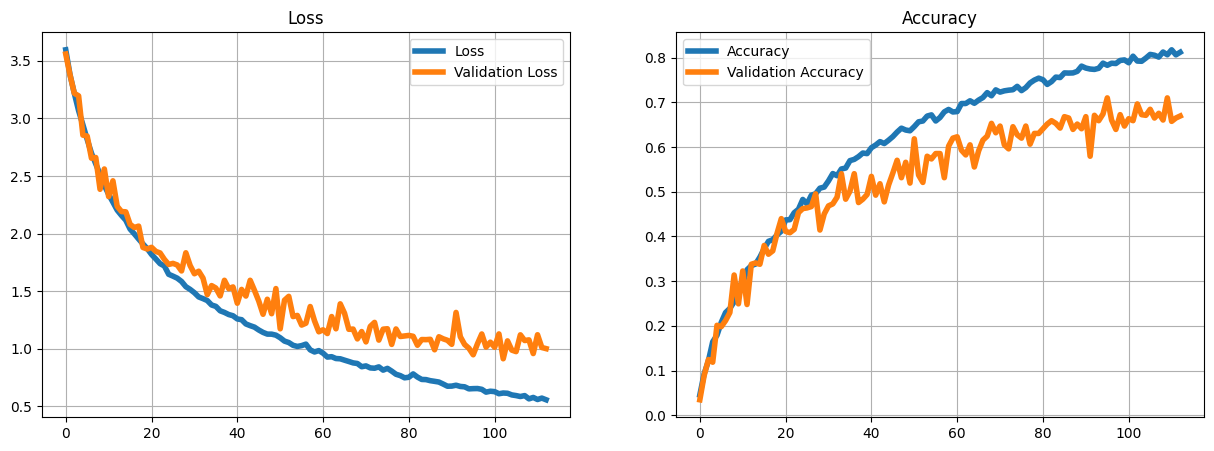

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axes[0].plot(history.history['loss'], linewidth=4, label='Loss')
axes[0].plot(history.history['val_loss'], linewidth=4, label='Validation Loss')
axes[0].set_title('Loss')
axes[0].grid(True)
axes[0].legend()

axes[1].plot(history.history['accuracy'], linewidth=4, label='Accuracy')
axes[1].plot(history.history['val_accuracy'], linewidth=4, label='Validation Accuracy')
axes[1].set_title('Accuracy')
axes[1].grid(True)
axes[1].legend()


In [ ]:
# Save history
write_list(history.history['sparse_categorical_accuracy'], 'accuracy')
write_list(history.history['val_sparse_categorical_accuracy'], 'val_accuracy')
write_list(history.history['loss'], 'loss')
write_list(history.history['val_loss'], 'val_loss')